# This program is developed by Soheil Hekmat



# 0.Version Check

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.32.1
aiohappyeyeballs                 2.4.0
aiohttp                          3.10.5
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.13
albumentations                   1.4.14
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.18.0
asn1crypto                       1.5.1
astropy                          6.1.2
astropy-iers-data                0.2024.8.26.0.31.57
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            24.2.0
audioread              

# 1.Setting up GPU and Libraries

In [1]:
import tensorflow as tf
import os

In [2]:
# Bringing in tensorflow
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


# 2.Loading Dataset

In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [6]:
!kaggle datasets download -d fantacher/neu-metal-surface-defects-data

Dataset URL: https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data
License(s): other
 59% 34.0M/57.4M [00:00<00:00, 81.2MB/s]
100% 57.4M/57.4M [00:00<00:00, 104MB/s] 


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/neu-metal-surface-defects-data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# 3.Data Preprocessing

In [21]:
data_dir = 'NEU Metal Surface Defects Data'
train_dir = "/content/NEU Metal Surface Defects Data/train"
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [22]:
os.listdir(data_dir)

['test', 'train', 'valid', 'Thumbs.db']

In [23]:
os.listdir(os.path.join(data_dir, 'train'))

['Pitted', 'Crazing', 'Inclusion', 'Rolled', 'Scratches', 'Patches']

In [24]:
os.listdir(os.path.join(data_dir, 'test'))

['Pitted', 'Crazing', 'Inclusion', 'Rolled', 'Scratches', 'Patches']

In [25]:
os.listdir(os.path.join(data_dir, 'valid'))

['Pitted', 'Crazing', 'Inclusion', 'Rolled', 'Scratches', 'Patches']

In [26]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 1800 files belonging to 3 classes.


In [27]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir)

Found 1656 files belonging to 6 classes.


In [28]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [29]:
# Setup connection aka iterator
# data_iterator = data.as_numpy_iterator()
data_iterator = train_data.as_numpy_iterator()

In [41]:
# Getting data out of the pipeline
batch = data_iterator.next()

In [39]:
batch[0].shape


(32, 256, 256, 3)

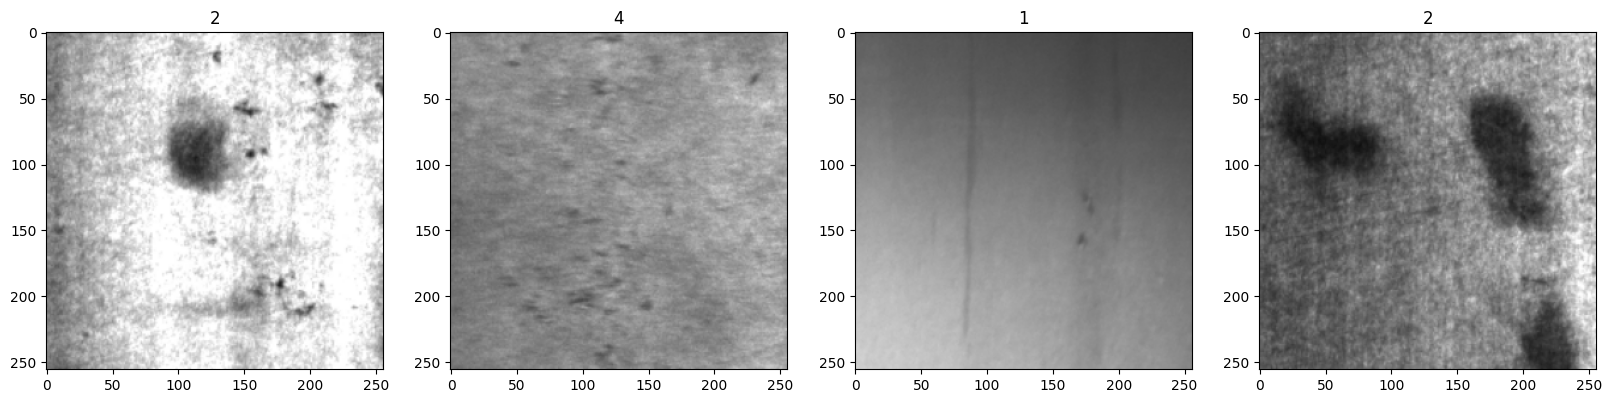

In [42]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4.Train, Test and Valid Split

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout

In [ ]:
train_dir = "/content/NEU Metal Surface Defects Data/train"
test_dir = "/content/NEU Metal Surface Defects Data/test"
valid_dir = "/content/NEU Metal Surface Defects Data/valid"

Let's Shuffle

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)


#get the images from train datagen
train_generator = train_datagen.flow_from_directory(train_dir,
                                              target_size=(256, 256),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)
valid_generator = test_datagen.flow_from_directory(valid_dir,
                                              target_size=(256, 256),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                              target_size=(256, 256),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [ ]:
#checking for batch size
for image_batch , labels_batch in train_generator :
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32, 6)


In [ ]:
#checking for class names
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


In [ ]:
#making functions
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names[label_index]

    return image, label_name


def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

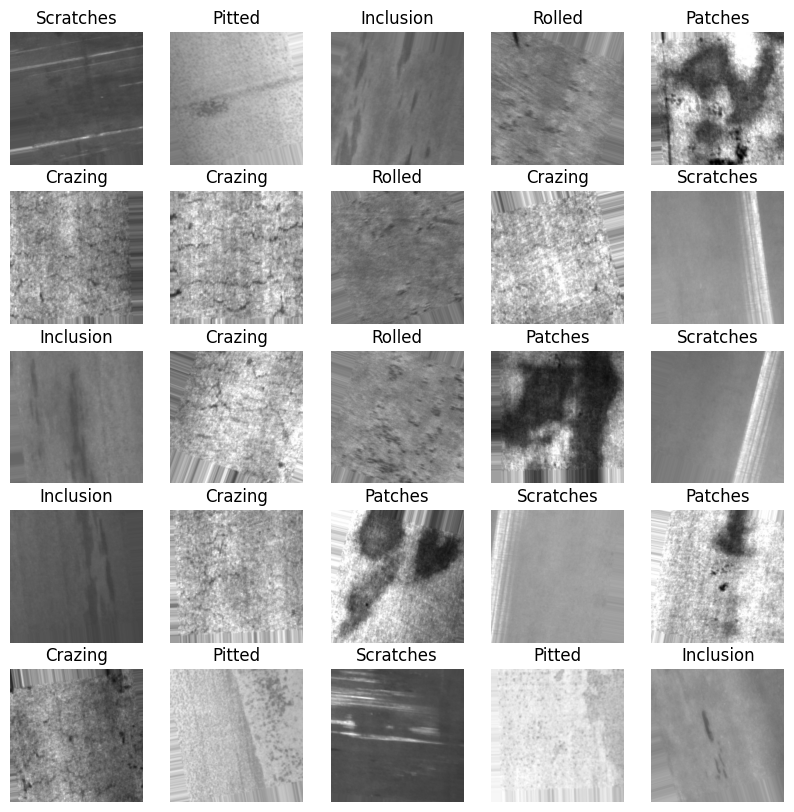

In [ ]:
sample_images(train_generator, nrows=5, ncols=5)

In [ ]:
labels_batch

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0.

# 5.Building Model With CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

Now we Train and Fit the Model

In [ ]:
# logdir='logs'
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train_generator, epochs=20, validation_data=valid_generator)
# , callbacks=[tensorboard_callback]

Epoch 1/20
52/52 [==============================] - 34s 544ms/step - loss: 0.4494 - accuracy: 0.2699 - val_loss: 0.3452 - val_accuracy: 0.5000
Epoch 2/20
52/52 [==============================] - 27s 523ms/step - loss: 0.2620 - accuracy: 0.6926 - val_loss: 0.2163 - val_accuracy: 0.7222
Epoch 3/20
52/52 [==============================] - 28s 539ms/step - loss: 0.2083 - accuracy: 0.7566 - val_loss: 0.1820 - val_accuracy: 0.6944
Epoch 4/20
52/52 [==============================] - 27s 529ms/step - loss: 0.1347 - accuracy: 0.8557 - val_loss: 0.0780 - val_accuracy: 0.9583
Epoch 5/20
52/52 [==============================] - 27s 529ms/step - loss: 0.0978 - accuracy: 0.8913 - val_loss: 0.0764 - val_accuracy: 0.9583
Epoch 6/20
52/52 [==============================] - 27s 525ms/step - loss: 0.0796 - accuracy: 0.9143 - val_loss: 0.0707 - val_accuracy: 0.9028
Epoch 7/20
52/52 [==============================] - 26s 506ms/step - loss: 0.0665 - accuracy: 0.9275 - val_loss: 0.0726 - val_accuracy: 0.9028

# 6.Plot and Performance

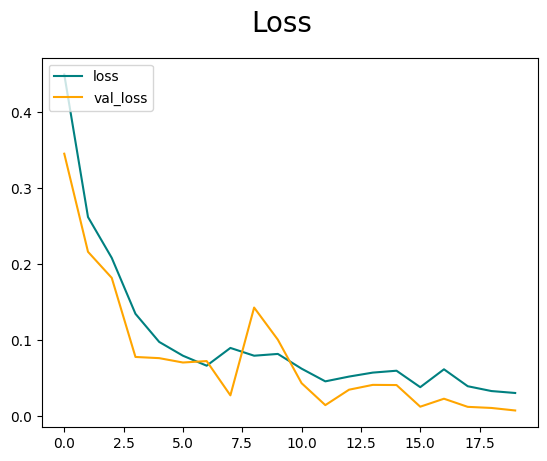

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

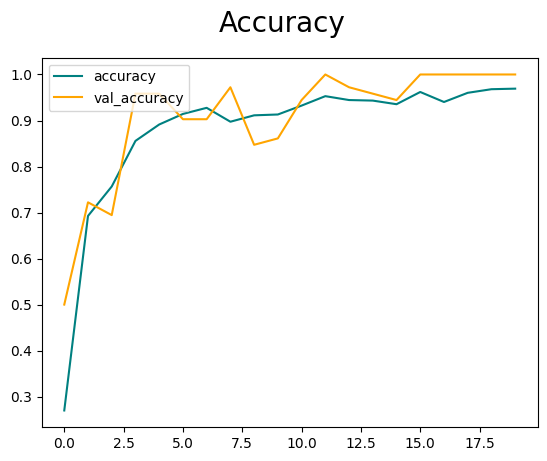

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
result = model.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)

3/3 [==============================] - 0s 37ms/step - loss: 0.0370 - accuracy: 0.9583
Test loss, Test accuracy :  [0.03698486462235451, 0.9583333134651184]


# 7.Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for image_batch , labels_batch in test_generator :
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32, 6)


In [ ]:
count = 0
for X, y in test_generator:
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    count = count + 1
    if count > 250:
      break

1/1 [==============================] - 0s 22ms/step


In [ ]:
print('precision is:', f'{pre.result()}')
print('recall is:', f'{re.result()}')
print('accuracy is:', f'{acc.result()}')

precision is: 0.9575185179710388
recall is: 0.9441489577293396
accuracy is: 0.9837101101875305


1/1 [==============================] - 0s 343ms/step


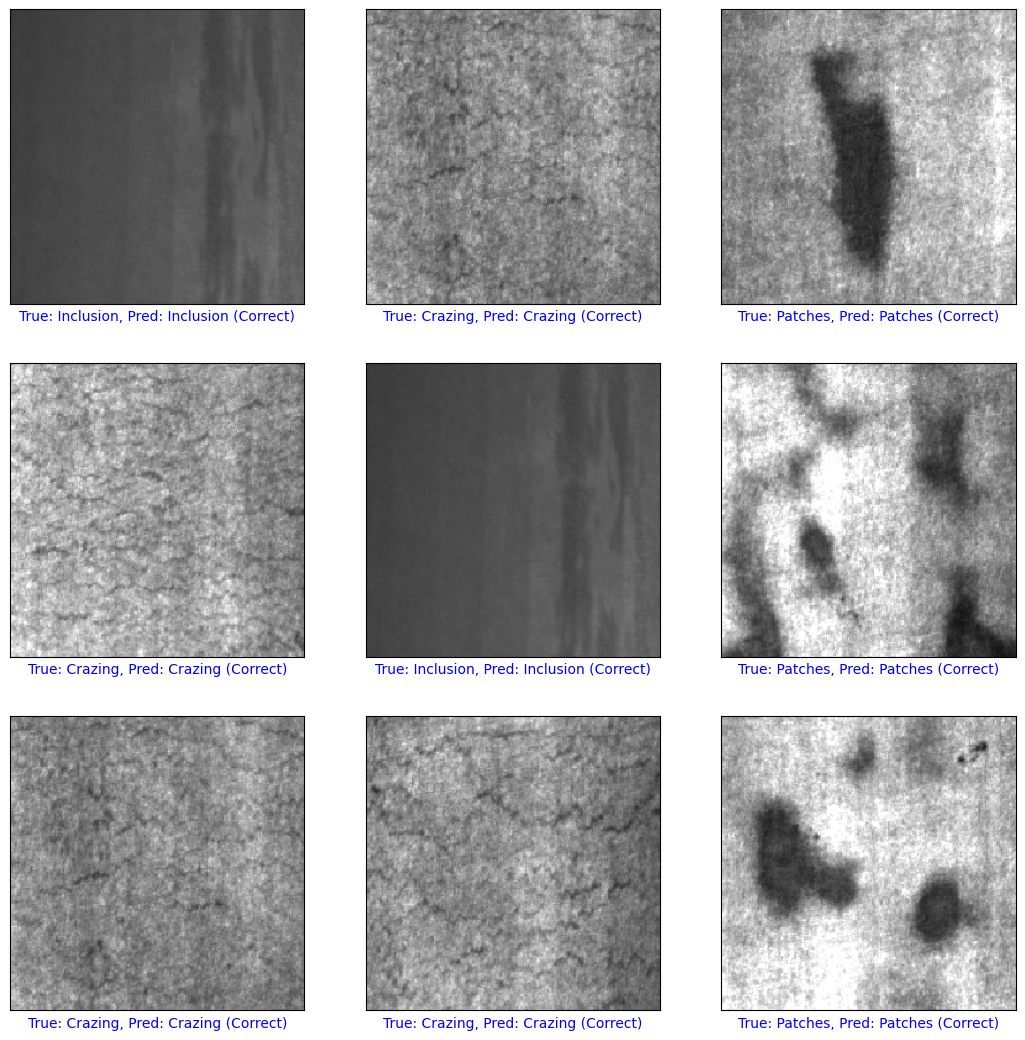

In [ ]:
images, labels = next(test_generator)

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = model.predict(images)


class_names=list(test_generator.class_indices.keys())


plt.figure(figsize=(13,13))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = images[i]

    if image.shape[-1] == 1:
        image = np.squeeze(image)

    plt.imshow(image)

    predicted_label = np.argmax(predictions[i])

    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"

    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"

    plt.xlabel(label_text,color=color)